In [288]:
pip install -qU langchain dotenv requests pandas

Note: you may need to restart the kernel to use updated packages.


In [289]:
from dotenv import load_dotenv
load_dotenv()

True

In [290]:
import os

# Environment
SENTRY_AUTH_TOKEN = os.environ.get("SENTRY_AUTH_TOKEN")
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")

# Sentry
SENTRY_URL = "https://sentry.io/api/0/projects/coffeeteastudios/apple-ios/issues/"
SENTRY_HEADERS = {
    "Authorization": f"Bearer {SENTRY_AUTH_TOKEN}",
    "Content-Type": "application/json"
}

# Trello
TRELLO_API_KEY = os.environ.get("TRELLO_API_KEY")
TRELLO_API_TOKEN = os.environ.get("TRELLO_API_TOKEN")

In [291]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(api_key=OPENAI_API_KEY, model="gpt-4o", temperature=0)

In [292]:
# Models

from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from typing import List
from typing import Optional

class Issue(BaseModel):
    id: str = Field(..., description="The id of the issue.")
    title: str = Field(..., description="The title of the issue.")
    number_of_occurrences: int = Field(..., description="The number of occurrences this issue has.")
    priority: int = Field(..., description="The priority of this issue from starting from 0. 0 is the highest priority.")

class IssueList(BaseModel):
    issues: List[Issue] = Field(default_factory=list, description="A list of issues from Sentry.")

class JiraTicket(BaseModel):
    id: str = Field(..., description="The id of the ticket.")
    summary: str = Field(..., description="A brief summary or title of the issue.")
    description: str = Field(..., description="Details of the issue.")
    assignee: str = Field(..., description="The assignee for this ticket.")

class AnalysisState(BaseModel):
    issues: List[Issue] = Field(default_factory=list, description="A collection of issues from Sentry.")
    high_priority_frontend_issue: Optional[Issue] = Field(None, description="The top issue that should be assigned to a frontend engineer.")
    frontend_jira_ticket: Optional[JiraTicket] = Field(None, description="A Jira ticket for frontend to address.")
    error_message: Optional[str] = Field(None, description="The error message if an error has occurred.")
    final_result: Optional[str] = Field(None, description="The summary of actions taken by the ai agent.")

issue_parser = PydanticOutputParser(pydantic_object=Issue)
issue_format_instructions = issue_parser.get_format_instructions()

issue_list_parser = PydanticOutputParser(pydantic_object=IssueList)
issue_list_format_instructions = issue_list_parser.get_format_instructions()

jira_parser = PydanticOutputParser(pydantic_object=JiraTicket)
jira_format_instructions = jira_parser.get_format_instructions()

analysis_parser = PydanticOutputParser(pydantic_object=AnalysisState)
analysis_format_instructions = analysis_parser.get_format_instructions()

In [293]:
# Sentry Methods
import requests

def get_recent_sentry_issues() -> dict:
    response = requests.get(SENTRY_URL, headers=SENTRY_HEADERS)
    if response.status_code != 200:
        raise Exception(f"Error fetching Sentry issue: {response.status_code} - {response.text}")
    return response.json()

In [294]:
from langchain_core.messages import HumanMessage

def recent_sentry_issues(state: AnalysisState) -> AnalysisState:
    """
    Retrieve and analyze recent Sentry issues.
    """
    # Renamed local variable to avoid confusion with the function name.
    raw_sentry_issues = get_recent_sentry_issues()
    prompt = f"""
    You are a technical project manager. Analyze the following Sentry issues:
    "{raw_sentry_issues}"
    Look for patterns in the logs and try to assign an id, title, and priority relative to the other issues. 
    Each issue should have a unique priority.
    {issue_list_format_instructions}
    """

    message = HumanMessage(content=prompt)
    response = llm.invoke([message])
    reply = response.content.strip()

    try:
        parsed_result = issue_list_parser.parse(reply)
        state.issues = parsed_result.issues
    except Exception as e:
        state.error_message = f"Failed at recent_sentry_issues. Error: {e}"
    return state


def prioritized_sentry_issues(state: AnalysisState) -> AnalysisState:
    """
    Determine the highest priority Sentry issue for a frontend engineer.
    """
    prompt = f"""
    You are an engineering manager. Analyze the following Sentry issues:
    "{state.issues}"
    Identify the highest priority issue that a frontend engineer should work on. Issues with 4XX status code are frontend issues. 
    {issue_format_instructions}
    """

    message = HumanMessage(content=prompt)
    response = llm.invoke([message])
    reply = response.content.strip()

    try:
        parsed_result = issue_parser.parse(reply)
        state.high_priority_frontend_issue = parsed_result
    except Exception as e:
        state.error_message = f"Failed to find the highest frontend issue. Error: {e}"
    return state


def create_jira_ticket(state: AnalysisState) -> AnalysisState:
    """
    Create a JIRA ticket for the highest priority frontend issue.

    This function uses the highest priority frontend issue from the state to create a JIRA ticket.
    """
    issue = state.high_priority_frontend_issue
    jira_ticket = JiraTicket(
        id=issue.id,
        summary=issue.title,
        description=f"This frontend issue has occurred {issue.number_of_occurrences} times.",
        assignee="kelvin"
    )
    state.frontend_jira_ticket = jira_ticket
    return state


def post_jira_ticket_to_trello(state: AnalysisState) -> AnalysisState:
    """
    This function makes creates a new Trello card, capturing the top frontend priority issue.
    """
    url = "https://api.trello.com/1/cards"
    ticket = state.frontend_jira_ticket

    payload = {
        "idList": "67d10aa8420fd0490816c460",
        "name": ticket.summary,
        "desc": f"Ticket ID: {ticket.id}\n\nDescription: {ticket.description}\n\nAssignee: {ticket.assignee}",
        "key": TRELLO_API_KEY,
        "token": TRELLO_API_TOKEN,
    }
    
    try:
        response = requests.post(url, data=payload)
        response.raise_for_status()
    except requests.exceptions.HTTPError as http_err:
        state.error_message = f"HTTP error occurred: {http_err}. Response: {response.text}"
    except Exception as err:
        state.error_message = f"An error occurred: {err}"
    
    return state


def summarizer(state: AnalysisState) -> AnalysisState:
    """
    Generates a summary of what the agent did. 
    """
    prompt = f"""
    Based on the following data "{state}", can you summarize the things that were done? Ignore fields that are None.
    """

    message = HumanMessage(content=prompt)
    response = llm.invoke([message])
    reply = response.content.strip()
    state.final_result = reply
    return state

In [295]:
# Graph assembly
from langgraph.graph import StateGraph, START, END

graph = StateGraph(AnalysisState)

graph.add_node("recent_sentry_issues", recent_sentry_issues)
graph.add_node("summarizer", summarizer)
graph.add_node("prioritized_sentry_issues", prioritized_sentry_issues)
graph.add_node("create_jira_ticket", create_jira_ticket)
graph.add_node("post_jira_ticket_to_trello", post_jira_ticket_to_trello)

graph.add_edge(START, "recent_sentry_issues")
graph.add_conditional_edges(
    "recent_sentry_issues",
    lambda state: state.error_message == None,
    {True: "prioritized_sentry_issues", False: END}
)

graph.add_conditional_edges(
    "prioritized_sentry_issues",
    lambda state: state.error_message == None,
    {True: "create_jira_ticket", False: END}
)
    
graph.add_edge("create_jira_ticket", "post_jira_ticket_to_trello")
graph.add_conditional_edges(
    "post_jira_ticket_to_trello",
    lambda state: state.error_message == None,
    {True: "summarizer", False: END}
)

graph.add_edge("summarizer", END)

app = graph.compile()

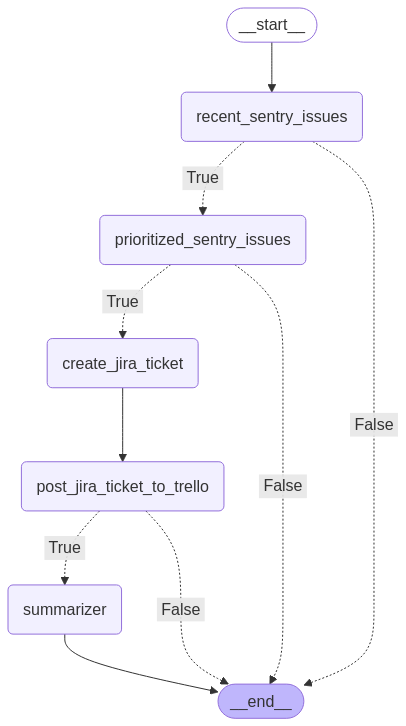

In [296]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [297]:
def run_agent():
    initial_state = AnalysisState(issues=[])
    thread = {"configurable": {"thread_id": "1"}}
    response = app.invoke(initial_state)
    return response

In [303]:
import json

response = run_agent()

In [304]:
print(response.get("final_result"))

Based on the provided data, the following actions were taken:

1. A list of issues was identified, each with a unique ID, title, number of occurrences, and priority level. The issues range from server errors like "504 Gateway Timeout" and "500 Internal Server Error" to client errors like "404 Not Found" and "400 Bad Request."

2. A specific high-priority frontend issue was highlighted: the "404 Not Found" error, which occurred 53 times and was assigned a priority level of 3.

3. A Jira ticket was created for the high-priority frontend issue. The ticket includes:
   - ID: 6376845753
   - Summary: "404 Not Found: The requested resource could not be found on this server."
   - Description: "This frontend issue has occurred 53 times."
   - Assignee: Kelvin

These actions indicate a focus on addressing the "404 Not Found" issue due to its high priority and frequency of occurrence.
